# Part 1 Topic Classification
zID: z5359551
Name: Donren Leung

Part 1 of the assignment is to examine various supervised machine learning methods using a variety of features and settings to determine what methods work best for topic classification in this song lyric domain/dataset. For this purpose, simply concatenate all the information for one song into a single “document”. You will use Bernoulli Naive Bayes from the tutorial, Multinomial Naive Bayes from the lecture, and one other machine learning method of your choice from scikit-learn or another machine learning library, and NLTK for auxiliary functions if needed.

## Overview of NLP Pipeline

1. **Loading the Dataset, Train/Test Splitting, and Cleansing**
2. **Data Text Preprocessing**
3. **Feature Extraction (Vectorisation)**
4. **Constructing the Cross-Validation Folds**
5. **Model Training (With Naive Bayes and Support Vector Machine Models)**:
6. **Model Evaluation and Comparison**

In [1]:
# 1. Loading the Dataset, Train/Test Splitting, and Cleansing
import pandas as pd
from sklearn.model_selection import train_test_split
df_original = pd.read_csv('dataset.tsv', sep='\t')

print(df_original.head(3))
print(len(df_original))

print("\n====== Deduplication and dropping NA values")

# Drop duplicates and missing values
df_original = df_original.drop_duplicates()
df_original = df_original.dropna()
print(df_original.info())

# Split off a held-out test set (15% of data)
df_train, df_test = train_test_split(
    df_original,
    test_size=0.15,
    stratify=df_original['topic'],
    random_state=42
)
print(f"\n====== Held-out test set size: {len(df_test)} samples ({len(df_test)/len(df_original):.1%})")

  artist_name         track_name  release_date  genre   
0      loving  the not real lake          2016   rock  \
1     incubus    into the summer          2019   rock   
2   reignwolf           hardcore          2016  blues   

                                              lyrics      topic  
0  awake know go see time clear world mirror worl...       dark  
1  shouldn summer pretty build spill ready overfl...  lifestyle  
2  lose deep catch breath think say try break wal...    sadness  
1500

====== Deduplication and dropping NA values
<class 'pandas.core.frame.DataFrame'>
Index: 1480 entries, 0 to 1499
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   artist_name   1480 non-null   object
 1   track_name    1480 non-null   object
 2   release_date  1480 non-null   int64 
 3   genre         1480 non-null   object
 4   lyrics        1480 non-null   object
 5   topic         1480 non-null   object
dtypes: int64(1), ob

## Part 1 Question 1
**There are a few simplifications in the Jupyter notebook in the tutorial: (i) the regex might remove too many special characters, and (ii) the evaluation is based on only one training-test split rather than using cross-validation. Explain how you are going to fix these mistakes and then highlight any changes to the code in the answers to the next questions.**

(i)
The original regex pattern `[^\w\s]` deletes all characters that are *not* any of the alphanumerical/underscore/whitespace characters. It seems that the lyrics in the provided `dataset.tsv` have already been preprocessed with this regex rule, as well as with stopwords removed, since the resulting lyrics column skips over certain words and do not contain frequent words, or those with hyphens or apostrophes. Therefore, if we wanted to apply a more lenient regex pattern to the lyrics, we would have to start from the original lyrics again -- **not possible without this file being provided**.

More relevant to the provided file for songs: beyond the lyrics (which we can't salvage), if we were to simply concatentate all the information (artist, title, lyrics etc.) into one "document" for NLP purposes, we may actually want to preserve the punctuation and other characters within the *artist name*. This would make those tokens more distinct and salient as a feature, rather than let it 'get lost' with the song lyrics. Hence the following new pattern `[^\w\s!@#$%&'’,.-]`.

(ii) Relying on one split can give unreliable performance estimates. Instead, we should replace `train_test_split` with `StratifiedKFold(n_splits=5, shuffle=True)`, to make 5 random cross-validations, and `cross_val_score` for an aggregate evaluation of all the folds.

In [2]:
# 2.Text Preprocessing (Text Sanitisation)
import nltk
import re
from typing import Optional
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')

ps = PorterStemmer()
nltk_stop = set(stopwords.words('english'))
skl_stop  = set(ENGLISH_STOP_WORDS)

# Define preprocessing function, with flexible params
def preprocess_text(text, relax_re: bool, stop_words: set, stem: bool):
    text = text.lower()
    if relax_re:
        text = re.sub(r"[^\w\s!@#$%&'’,.]", '', text)
    else:
        text = re.sub(r'[^\w\s]', '', text)

    tokens = word_tokenize(text)

    if stop_words:
        tokens = [word for word in tokens if word not in stop_words]
    if stem:
        tokens = [ps.stem(word) for word in tokens]
    
    return ' '.join(tokens)

def apply_preprocessing(df, descr: str,
                            artist_params: tuple[bool, set, bool],
                            track_params:  tuple[bool, set, bool],
                            lyrics_params: tuple[bool, set, bool]
                        ) -> pd.DataFrame:
    print(f"\n====== New Preprocess Run: {descr:<70} ==========")
    df: pd.DataFrame = df.copy()

    df['artist_name'] = df['artist_name'].apply(preprocess_text, args=artist_params)
    df['track_name'] = df['track_name'].apply(preprocess_text, args=track_params)
    df['lyrics'] = df['lyrics'].apply(preprocess_text, args=lyrics_params)

    df['concat'] = df.drop('topic', axis=1).astype(str).agg(' '.join, axis=1)
    return df


[nltk_data] Downloading package stopwords to /home/don/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/don/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /home/don/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [3]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.model_selection import cross_val_score, cross_val_predict, StratifiedKFold

# Apply preprocessing to each document according to given params
# And train with models (b-nb and m-nb)
def vectorize(df, max_features: Optional[int]=None):
    # 3. Feature Extraction (Vectorisation - simple count of each word in vocab that is in each song's doc)
    vectorizer = CountVectorizer(max_features=max_features)
    X = vectorizer.fit_transform(df['concat'])
    y = df['topic']
    print(f"Vector shapes - X: {X.shape}, y: {y.shape}")

    return X, y, vectorizer

# Run comparison between Bernoulli and Multinomial Naive Bayes with 5-fold stratified CV
# Using a basic accuracy metric + stddev
def train_simple(X, y):
    bnb = BernoulliNB()
    mnb = MultinomialNB()

    # 4. Constructing the Cross-Validation Folds
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # 5. Model Training (With Naive Bayes)
    scores_bnb = cross_val_score(bnb, X, y, cv=cv, scoring='accuracy')
    scores_mnb = cross_val_score(mnb, X, y, cv=cv, scoring='accuracy')

    # 6. Model Evaluation and Comparison
    print(f"Bernoulli NB 5-fold CV accuracy: {scores_bnb.mean():.3f} ± {scores_bnb.std():.3f}")
    print(f"Multinomial NB 5-fold CV accuracy: {scores_mnb.mean():.3f} ± {scores_mnb.std():.3f}")

In [4]:
# Manual Preprocessing-Hyperparameter Search
# As a reminder, the hypothesis was that passing in to the document extra information about artist,
# by preserving all words and punctuation, would improve accuracy by containing tokens with some probability
# to be distinct to lyric tokens (which don't have punctuation)
df_train_concat = apply_preprocessing(df_train, 'Hypothesis (relaxed artist regex, NLTK stop/stem title+lyrics)',
                                artist_params=(True, {}, False),
                                track_params=(False, nltk_stop, True),
                                lyrics_params=(False, nltk_stop, True))
X, y, _ = vectorize(df_train_concat)
train_simple(X, y)

df_train_concat = apply_preprocessing(df_train, 'Hypothesis (relaxed artist regex, sklearn stop/stem title+lyrics)',
                                artist_params=(True, {}, False),
                                track_params=(False, skl_stop, True),
                                lyrics_params=(False, skl_stop, True))
X, y, _ = vectorize(df_train_concat)
train_simple(X, y)

df_train_concat = apply_preprocessing(df_train, 'Relaxed (relaxed artist regex, no stop/stem)',
                                artist_params=(True, False, False),
                                track_params=(True, {}, False),
                                lyrics_params=(True, {}, False))
X, y, _ = vectorize(df_train_concat)
train_simple(X, y)

df_train_concat = apply_preprocessing(df_train, 'Strict (all NLTK stop/stem)',
                                artist_params=(False, nltk_stop, True),
                                track_params=(False, nltk_stop, True),
                                lyrics_params=(False, nltk_stop, True))
X, y, _ = vectorize(df_train_concat)
train_simple(X, y)

df_train_concat = apply_preprocessing(df_train, 'Strict (all sklearn stop/stem)',
                                artist_params=(False, skl_stop, True),
                                track_params=(False, skl_stop, True),
                                lyrics_params=(False, skl_stop, True))
X, y, _ = vectorize(df_train_concat)
train_simple(X, y)

df_train_concat = apply_preprocessing(df_train, 'Hypothesis + stop only (relaxed artist regex, NLTK stop title+lyrics)',
                                artist_params=(True, {}, False),
                                track_params=(False, nltk_stop, False),
                                lyrics_params=(False, nltk_stop, False))
X, y, _ = vectorize(df_train_concat)
train_simple(X, y)

df_train_concat = apply_preprocessing(df_train, 'Hypothesis + stem only (relaxed artist regex, stem title+lyrics)',
                                artist_params=(True, {}, False),
                                track_params=(False, {}, True),
                                lyrics_params=(False, {}, True))
X, y, _ = vectorize(df_train_concat)
train_simple(X, y)


====== New Preprocess Run: Hypothesis (relaxed artist regex, NLTK stop/stem title+lyrics)         ==========
Vector shapes - X: (1258, 8249), y: (1258,)
Bernoulli NB 5-fold CV accuracy: 0.517 ± 0.038
Multinomial NB 5-fold CV accuracy: 0.779 ± 0.026

====== New Preprocess Run: Hypothesis (relaxed artist regex, sklearn stop/stem title+lyrics)      ==========
Vector shapes - X: (1258, 8205), y: (1258,)
Bernoulli NB 5-fold CV accuracy: 0.522 ± 0.043
Multinomial NB 5-fold CV accuracy: 0.773 ± 0.032

====== New Preprocess Run: Relaxed (relaxed artist regex, no stop/stem)                           ==========
Vector shapes - X: (1258, 9093), y: (1258,)
Bernoulli NB 5-fold CV accuracy: 0.519 ± 0.038
Multinomial NB 5-fold CV accuracy: 0.780 ± 0.028

====== New Preprocess Run: Strict (all NLTK stop/stem)                                            ==========
Vector shapes - X: (1258, 8074), y: (1258,)
Bernoulli NB 5-fold CV accuracy: 0.524 ± 0.044
Multinomial NB 5-fold CV accuracy: 0.777 ± 0.028


## Part 1 Question 2
**Develop a Multinomial Naive Bayes (MNB) model similar to the Bernoulli Naive Bayes (BNB) model. Now consider all the steps in text preprocessing used prior to classification with both BNB and MNB. The aim here is to find preprocessing steps that maximize overall accuracy (under the default settings of the classifiers and using CountVectorizer with the standard settings). Consider the special characters to be removed (and how and when they are removed),
the definition of a “word”, the stopword list (from either NLTK or scikit-learn), lowercasing and stemming/lemmatization. Summarize the preprocessing steps that you think work “best” overall and do not change this for the rest of the assignment.**

The above cell displays the results of varying manually-set parameters for text preprocessing -- different combinations for regex pattern, stopword list and stemming. While the resulting `CountVector` varies in size (8.8k-10k), the accuracy does not vary to a significant degree (within <1 std. dev.) -- Bernoulli NB ranges from 51.7-52.9% and Multinomial NB 77.3%-78.4%. This is likely due to the fact that the lyrics, a large part of the text, has already been heavily pre-processed, with lowercasing, punctuation, and stopword filtering applied. As a result, any difference that potentially exists between different settings is diminished in the final output of the preprocessing pipeline.

As for the definition of a "word", the tokenizer used in this project is `nltk.word_tokenize`, which is based on the Penn Treebank tokenizer. It is designed primarily for English text and uses regular expressions to split tokens based on spaces, punctuation, and some contractions. This wouldn't work for non-English lyrics, such as the three Korean songs (T-Rock, *Be A G About It*, BTS, *Not Today*, and Dua Lipa, *Kiss and Make Up*), where characters are grouped chunks containing multiple words.

An experimental result (not shown), where each Hangul character was made its own token, showed a ~0.01-0.02% improvement across the board. However, Korean words are a block of characters -- so for proper processing, it would require a proper Korean tokeniser to correctly break up and group Hangul characters, but the small size of these songs makes it not worth it to include this step.

Thus, with all things considered, future preprocessing steps from this point will follow `relaxed artist regex, NLTK stop/stem title+lyrics`:
1. For each record (text in 5 X columns and 1 y column):
2. Filter out characters with regex: `[^\w\s!@#$%&'’,.-]` for text in Artist Name and `[^\w\s]` for Track Title and Lyrics
3. Convert text strings to a list of tokens with `nltk.word_tokenize`
4. For Title and Lyrics, filter out stop words and stem.
5. Combine Artist Name, Track Title, Release Year, Genre, and Lyrics into one CountVector as the X, with Topic as the y.

## Part 1 Question 3
**Compare BNB and MNB models by evaluating them using the full dataset with cross-validation. Choose appropriate metrics from those in the lecture that focus on the overall accuracy of classification (i.e. not top-N metrics). Briefly discuss the tradeoffs between the various metrics and then justify your choice of the main metrics for evaluation, taking into account whether this dataset is balanced or imbalanced. On this basis, conclude whether either of BNB or MNB is superior. Justify this conclusion with plots/tables.**


In [5]:
print("Total", df_train['topic'].value_counts())

print("Class Tallies")
print(df_train['topic'].value_counts())
print("Class Proportion Percentages:")
print(df_train['topic'].value_counts() / sum(df_train['topic'].value_counts()))

Total topic
dark         414
sadness      315
personal     290
lifestyle    172
emotion       67
Name: count, dtype: int64
Class Tallies
topic
dark         414
sadness      315
personal     290
lifestyle    172
emotion       67
Name: count, dtype: int64
Class Proportion Percentages:
topic
dark         0.329094
sadness      0.250397
personal     0.230525
lifestyle    0.136725
emotion      0.053259
Name: count, dtype: float64


With the smallest class ("emotion") only 5% of the corpus and the largest nearly 33%, the distribution is somewhat imbalanced. A classifier that simply predicts the majority class would reach an apparent accuracy of 33%, so raw accuracy can look adequate even when minority classes are ignored.

Because we care about all topics (a user would not want a playlist full of "dark" tracks when they asked for "emotion"), the metric should not overly favour majority classes.

### Metric tradeoffs
**Overall Accuracy** - measures proportion of total correct predictions over all predictions.
```txt
++ Simple to compute and explain, and is reasonable if the dataset is balanced.
-- Biased towards majority classes in imbalanced data.
```

**Balanced Accuracy** - average of recall scores across all classes.
```txt
++ Each class contributes equally no matter the size; robust to imbalance.
-- Ignores precision (a high recall by overpredicting a class could inflate the score)
```

**Macro-Averaged F1 Score** - average of within-class F1 measures.
```txt
++ Balances both precision and recall for each class, and a model must do well on every class to score high.
-- Can be disproportionately lowered by poor performance on rare classes.
```

**Weighted-Averaged F1 Score** - support-weighted average of within-class F1 measures.
```txt
++ Also considers both precision and recall for each class, less sensitive to rare classes.
-- Tends to correlate with overall accuracy in imbalanced data (due to major classes dominating).
```

**Micro-Averaged F1 Score** - aggregate, global F1 measure across all classes.
```txt
++ Reflects overall volume: every individual prediction counts equally.
-- Large classes with many examples will drive the score, masking poor performance on smaller classes.
```

Thus, we will use `f1_macro` as our main metric, with `accuracy` and `balanced_accuracy` as supplementary metrics. Together, they should give a holistic view of the performance of the models across both dominant and minority topics, which is key to create a recommender system that can suggest both common and nuanced moods/topics.



====== New Preprocess Run: Best-found preprocessing (relaxed artist regex, NLTK stop, stemming)   ==========
Vector shapes - X: (1258, 8249), y: (1258,)
Performance Results
                accuracy  balanced_accuracy  f1_macro
model                                                
Bernoulli_NB       0.517              0.372     0.328
Multinomial_NB     0.779              0.697     0.711


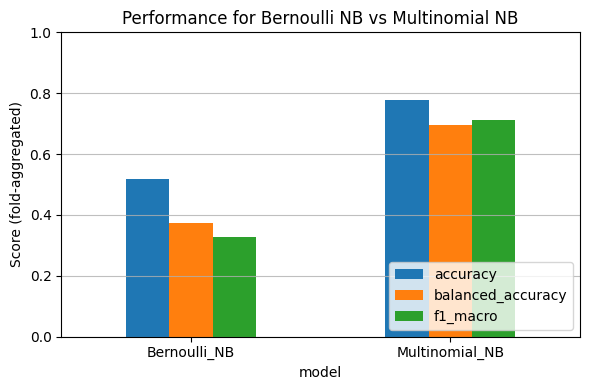

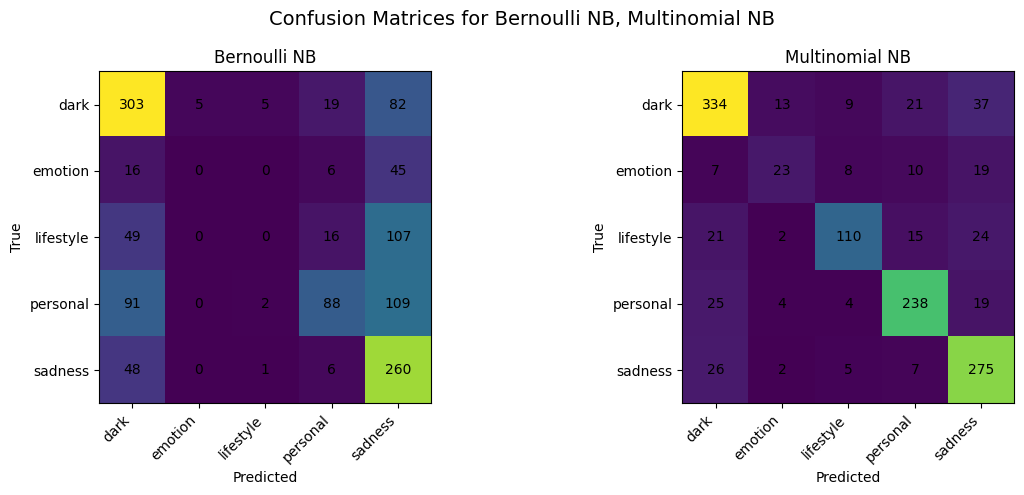

In [6]:
from sklearn.metrics import (accuracy_score, balanced_accuracy_score,
                             f1_score, confusion_matrix)
import matplotlib.pyplot as plt

def evaluate_models(X, y, model_dict, cv):
    """
    For each model, return a DataFrame with Accuracy, Balanced Acc, Macro-F1 metrics
    as well as predictions.
    """
    rows, all_preds = [], {}
    for name, clf in model_dict.items():
        y_pred = cross_val_predict(clf, X, y, cv=cv, n_jobs=-1)
        all_preds[name] = y_pred
        rows.append({
            "model":               name,
            "accuracy":            accuracy_score(y, y_pred),
            "balanced_accuracy":   balanced_accuracy_score(y, y_pred),
            "f1_macro":            f1_score(y, y_pred, average='macro')
        })

    return pd.DataFrame(rows).set_index("model"), all_preds

def make_confusion_matrix(labels, y_true, preds):
    cm_bnb = confusion_matrix(y_true, preds['Bernoulli_NB'], labels=labels)
    cm_bnb_df = pd.DataFrame(cm_bnb,
                            index=pd.Index(labels, name='True'),
                            columns=pd.Index(labels, name='Predicted'))
    
    cm_mnb = confusion_matrix(y_true, preds['Multinomial_NB'], labels=labels)
    cm_mnb_df = pd.DataFrame(cm_mnb,
                            index=pd.Index(labels, name='True'),
                            columns=pd.Index(labels, name='Predicted'))

    cms = [
        (cm_bnb_df, "Bernoulli NB"),
        (cm_mnb_df, "Multinomial NB")
    ]

    # Combine BNB & MNB heatmaps side by side with annotations
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    fig.suptitle(f"Confusion Matrices for {', '.join([tup[1] for tup in cms])}", fontsize=14)
    for ax, (cm_df, title) in zip(axes, cms):
        im = ax.imshow(cm_df.values, interpolation='nearest')
        ax.set_title(title)
        
        ax.set_xticks(range(len(cm_df.columns)))
        ax.set_xticklabels(cm_df.columns, rotation=45, ha='right')
        ax.set_xlabel('Predicted')

        ax.set_yticks(range(len(cm_df.index)))
        ax.set_yticklabels(cm_df.index)
        ax.set_ylabel('True')

        # Annotate each cell with its count
        for i in range(cm_df.shape[0]):
            for j in range(cm_df.shape[1]):
                ax.text(j, i, cm_df.iat[i, j], ha='center', va='center')

    plt.tight_layout()
    plt.show()

def run_experiment(df, descr,
                   artist_params, track_params, lyrics_params, *,
                   max_features: Optional[int]=None,
                   do_bar: bool,
                   do_cm: bool):
    # Preprocess
    df_concat = apply_preprocessing(df, descr, artist_params, track_params, lyrics_params)
    X, y, _ = vectorize(df_concat, max_features=max_features)

    # Train and Evaluate
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    results, preds = evaluate_models(
        X, y,
        model_dict={"Bernoulli_NB": BernoulliNB(),
                    "Multinomial_NB": MultinomialNB()},
        cv=cv
    )
    print("Performance Results")
    print(results.round(3))

    # Optional visualisations
    if do_bar:
        ax = results.plot(kind='bar', ylim=(0,1), figsize=(6,4), rot=0)
        if max_features is None:
            add_text = ""
        else:
            add_text = f" (top-{max_features} words)"
        ax.set_ylabel("Score (fold-aggregated)")
        ax.set_title(f"Performance for Bernoulli NB vs Multinomial NB{add_text}")
        ax.legend(loc='lower right')
        ax.grid(True, which="both", axis="y", alpha=0.8)

        plt.tight_layout()
        plt.show()

    if do_cm:
        make_confusion_matrix(sorted(y.unique()), y, preds)

    return results

best_params = (
    'Best-found preprocessing (relaxed artist regex, NLTK stop, stemming)',
    (True, {}, False),
    (False, nltk_stop, True),
    (False, nltk_stop, True)
)

_ =run_experiment(df_train, *best_params, do_bar=True, do_cm=True)

### Performance Comparison
Multinomial (MNB) is clearly better than Bernoulli Naive Bayes (BNB) across all metrics (51.7% vs 77.9% accuracy; 32.8% vs 71.1% macro-F1). In fact, in Q2, the solely-used accuracy metric masked BNB's lamentable performance in the two smallest categories of lifestyle and emotion (consisting 14% and 5% of the dataset respectively).

This is better elucidated in the confusion matrix generated for each model, where it is clear that BNB assigns most predictions to the bigger three classes, especially sadness, which has a lot of false positives from other classes. On the other hand, we see a bright diagonal in the MNB confusion matrix, demonstrating that it not only improves on overall accuracy, but also its ability to predict classes of *all* rarities.

## Part 1 Question 4

In [7]:
Ns = [50, 100, 200, 400, 800, 1600, 3200, 6400, 12800]
records = []

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for N in Ns:
    df_train_concat = apply_preprocessing(df_train, *best_params)
    X, y, _ = vectorize(df_train_concat, max_features=N)

    for name, clf in [("BNB", BernoulliNB()), ("MNB", MultinomialNB())]:
        y_test_pred = cross_val_predict(clf, X, y, cv=cv, n_jobs=-1)
        records.append({
            "model": name,
            "max_features": N,
            "macro_f1": f1_score(y, y_test_pred, average='macro'),
            "accuracy": balanced_accuracy_score(y, y_test_pred)
        })



====== New Preprocess Run: Best-found preprocessing (relaxed artist regex, NLTK stop, stemming)   ==========
Vector shapes - X: (1258, 50), y: (1258,)

====== New Preprocess Run: Best-found preprocessing (relaxed artist regex, NLTK stop, stemming)   ==========
Vector shapes - X: (1258, 100), y: (1258,)

====== New Preprocess Run: Best-found preprocessing (relaxed artist regex, NLTK stop, stemming)   ==========
Vector shapes - X: (1258, 200), y: (1258,)

====== New Preprocess Run: Best-found preprocessing (relaxed artist regex, NLTK stop, stemming)   ==========
Vector shapes - X: (1258, 400), y: (1258,)

====== New Preprocess Run: Best-found preprocessing (relaxed artist regex, NLTK stop, stemming)   ==========
Vector shapes - X: (1258, 800), y: (1258,)

====== New Preprocess Run: Best-found preprocessing (relaxed artist regex, NLTK stop, stemming)   ==========
Vector shapes - X: (1258, 1600), y: (1258,)

====== New Preprocess Run: Best-found preprocessing (relaxed artist regex, NLTK s

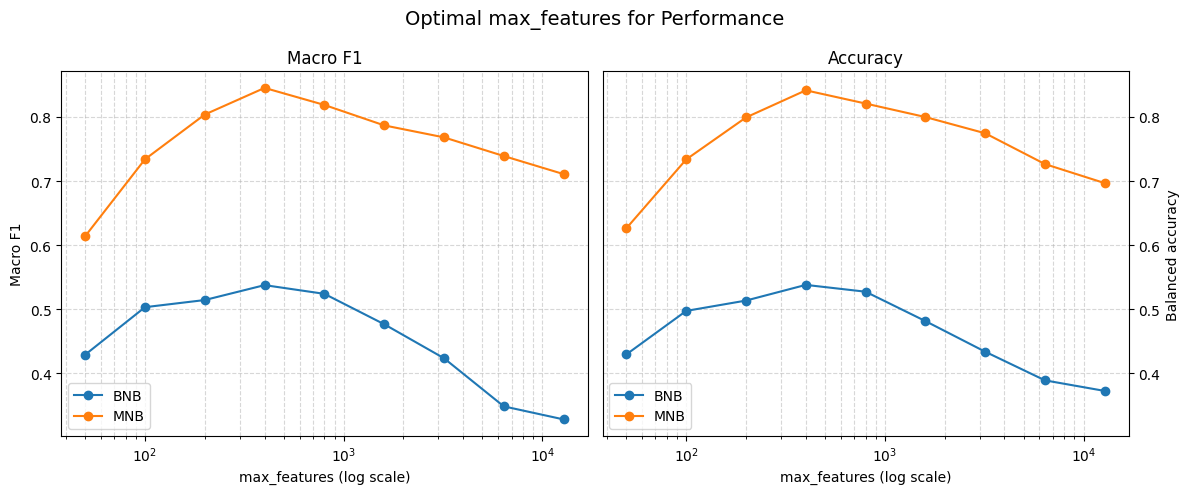

Model BNB - Best max_features: 400, Macro F1: 0.5374
Model MNB - Best max_features: 400, Macro F1: 0.8454


In [8]:
df_results = pd.DataFrame(records)

# Compute the global min/max across both metrics
y_min = df_results[['macro_f1','accuracy']].min().min()
y_max = df_results[['macro_f1','accuracy']].max().max()
padding = 0.02

# Create subplots with shared y-axis
fig, axes = plt.subplots(1, 2, figsize=(12,5), sharex=True, sharey=True)
fig.suptitle("Optimal max_features for Performance", fontsize=14)
for ax, metric in zip(axes, ["macro_f1", "accuracy"]):
    for model in ["BNB", "MNB"]:
        subset = df_results[df_results.model == model]
        ax.plot(subset.max_features,
                subset[metric],
                marker='o',
                label=model)
    ax.set_xscale('log')
    ax.set_xlabel("max_features (log scale)")

    # Place label & ticks on left only for macro_f1
    if metric == "macro_f1":
        ax.set_ylabel("Macro F1")
        ax.yaxis.set_label_position("left")
        ax.yaxis.set_ticks_position("left")
    else:
        # for balanced accuracy, move everything to the right
        ax.set_ylabel("Balanced accuracy")
        ax.yaxis.set_label_position("right")
        ax.yaxis.set_ticks_position("right")

    ax.set_title(metric.replace("_"," ").title())
    ax.legend(loc='lower left')
    ax.grid(True, which="both", ls="--", alpha=0.5)

plt.tight_layout()
plt.show()

# Print out the max_features that gives the highest macro_f1 for each model
for model in ["BNB", "MNB"]:
    subset = df_results[df_results.model == model]
    best_idx = subset['macro_f1'].idxmax()
    best_row = subset.loc[best_idx]
    print(f"Model {model} - Best max_features: {best_row['max_features']}, Macro F1: {best_row['macro_f1']:.4f}")

**Consider varying the number of features (words) used by BNB and MNB in the classification, using the sklearn setting which limits the number to the top N most frequent
words in the Vectorizer. Compare classification results for various values for N and justify, based on experimental results, one value for N that works well overall and use this value for the rest of the assignment. Show plots or tables that support your decision. The emphasis is on clear presentation of the results so do not print out large tables or too many tables that are difficult to understand.**

Through a 5-cross-folded sweep of the value N for `max_feature`, we find that the optimal value is 400, which is the peak for both `BernoulliNB` and `MultinomialNB` models in both macro-f1 (53.7% and 84.5% respectively) and accuracy -- a significantly better performance than the all-N value previously used. Too few features means less information needed to distinguish topics -- throwing away most of the vocabularly means important discriminative tokens (even moderately frequent ones) do not get modelled (underfitting). On the other hand, having too many features causes data sparsity and overfitting, and introduces rare and also abnormal tokens (typos, slang, song-specific words) which hurts the model's generalisation.

## Part 1 Question 5
**Choose one other machine learning method, perhaps one mentioned in the lecture. Summarize this method in a single tutorial-style paragraph and explain why you think it is suitable
for topic classification for this dataset (for example, maybe other people have used this method for a similar problem). Conduct experiments (and show the code for these experiments) using cross-validation and comment on whether you confirmed (or not) your hypothesis. Finally, compare this method to BNB and MNB on the metrics you used in Step 3 and choose one overall “best” method and settings for topic classification.**

### Tutorial Explanation
Support Vector Machines (SVMs) find an optimal decision boundary (hyperplane) by maximising the margin: the distance separating the hyperplane from the nearest points (support vectors) of each class in a high-dimensional feature space. This makes SVMs especially effective for text classification tasks, which usually involve sparse and high-dimensional data, such as the `CountVector` used here. `LinearSVC`, sklearn's implementation of SVM, efficiently optimizes this linear boundary, scaling well even with large feature sets. Due to its margin-based optimization, SVM is resilient to noisy or irrelevant features, positioning it well to outperform simpler approaches like Naive Bayes for our music topic classification task.

Hypothesis: `LinearSVC` will achieve an equal or higher performance to the `BernoulliNB` and `MultinomialNB` models in terms of accuracy, balanced accuracy, and macro-F1 scores. To determine the optimal hyperparameters, we will conduct a grid search varying `max_features` and the regularisation constant `C` using cross-validation. Finally, we will confirm our selected `LinearSVC` model by evaluating it on the held-out dataset and compare it with the Naive Bayes models.

In [9]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV

# Any smaller N and it seems to fail to converge
Ns = [400, 600, 800, 1000, 1600, 3200, 6400, 12800]
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10]}
base_svm = LinearSVC(random_state=42, max_iter=1000)
grid_scores = []

for N in Ns:
    df_train_concat = apply_preprocessing(df_train, *best_params)
    X_n, y_n, _ = vectorize(df_train_concat, max_features=N)

    grid = GridSearchCV(base_svm, param_grid, cv=cv, scoring='f1_macro', n_jobs=-1)
    grid.fit(X_n, y_n)
    svm_best_C = grid.best_params_['C']
    best_score = grid.best_score_
    print(f"max_features={N}: best C={svm_best_C}, CV macro-f1={best_score:.3f}")
    grid_scores.append({'max_features': N, 'C': svm_best_C, 'cv_macro_f1': best_score})

# Determine overall best settings
import pandas as pd
df_grid = pd.DataFrame(grid_scores)
best_idx = df_grid['cv_macro_f1'].idxmax()
svm_best_N, svm_best_C = df_grid.loc[best_idx, ['max_features', 'C']]
print(f"\nOverall best LinearSVC settings: max_features={svm_best_N}, C={svm_best_C}")



====== New Preprocess Run: Best-found preprocessing (relaxed artist regex, NLTK stop, stemming)   ==========
Vector shapes - X: (1258, 400), y: (1258,)
max_features=400: best C=0.01, CV macro-f1=0.845

====== New Preprocess Run: Best-found preprocessing (relaxed artist regex, NLTK stop, stemming)   ==========


/home/don/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/don/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Vector shapes - X: (1258, 600), y: (1258,)
max_features=600: best C=0.01, CV macro-f1=0.859

====== New Preprocess Run: Best-found preprocessing (relaxed artist regex, NLTK stop, stemming)   ==========
Vector shapes - X: (1258, 800), y: (1258,)
max_features=800: best C=0.01, CV macro-f1=0.851

====== New Preprocess Run: Best-found preprocessing (relaxed artist regex, NLTK stop, stemming)   ==========
Vector shapes - X: (1258, 1000), y: (1258,)
max_features=1000: best C=0.01, CV macro-f1=0.852

====== New Preprocess Run: Best-found preprocessing (relaxed artist regex, NLTK stop, stemming)   ==========
Vector shapes - X: (1258, 1600), y: (1258,)
max_features=1600: best C=0.01, CV macro-f1=0.845

====== New Preprocess Run: Best-found preprocessing (relaxed artist regex, NLTK stop, stemming)   ==========
Vector shapes - X: (1258, 3200), y: (1258,)
max_features=3200: best C=0.01, CV macro-f1=0.847

====== New Preprocess Run: Best-found preprocessing (relaxed artist regex, NLTK stop, stemmin


====== New Preprocess Run: Best-found preprocessing (relaxed artist regex, NLTK stop, stemming)   ==========
Vector shapes - X: (1258, 600), y: (1258,)
Vector shapes - X: (1258, 400), y: (1258,)

====== New Preprocess Run: Best-found preprocessing (relaxed artist regex, NLTK stop, stemming)   ==========
Held-out set performance:
                 accuracy  balanced_accuracy  f1_macro
model                                                
Bernoulli NB       0.626              0.547     0.558
Multinomial NB     0.847              0.811     0.814
Linear SVC         0.887              0.857     0.874


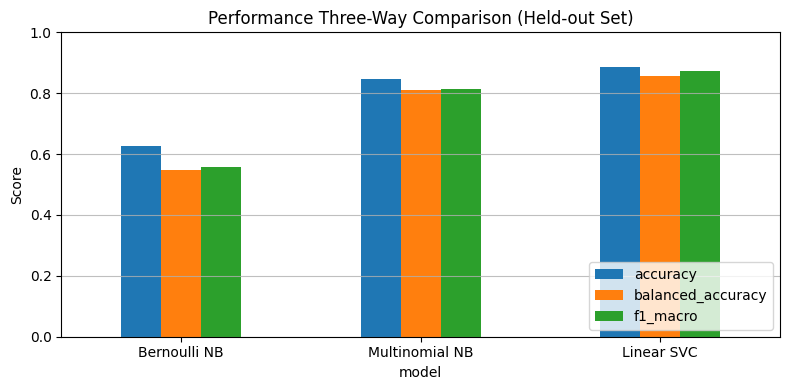

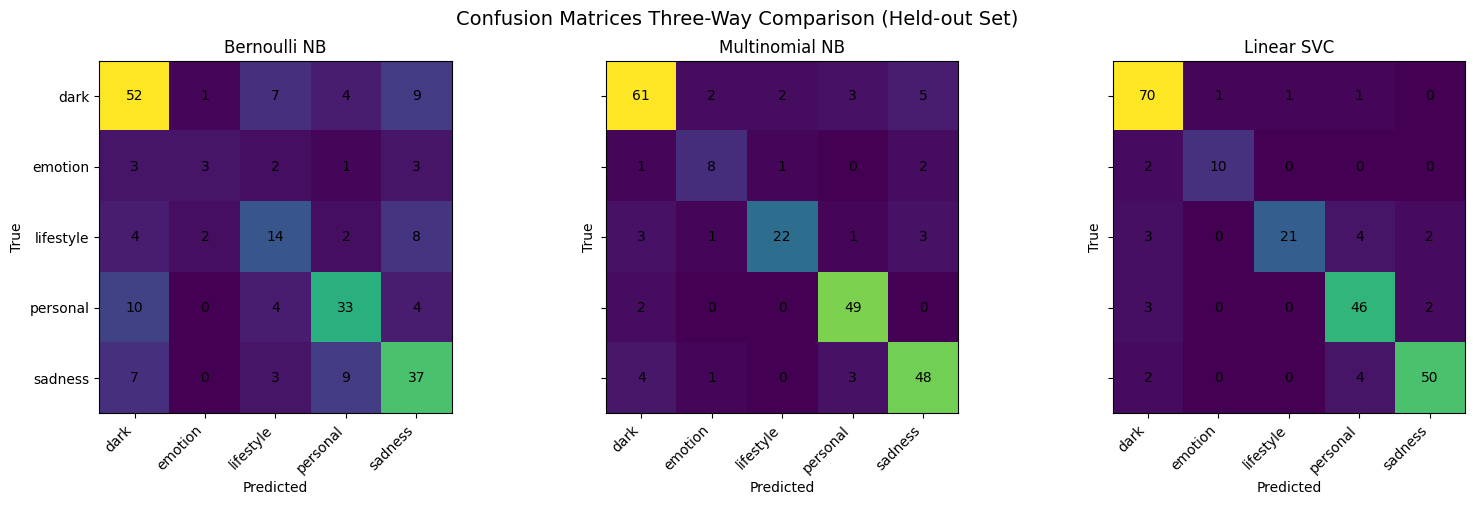

In [10]:
# Held-out evaluation for best LinearSVC, Bernoulli and Multinomial Naive Bayes
# Train all three models with best params on training set
df_train_concat = apply_preprocessing(df_train, *best_params)

X_train_svm, y_train_svm, vectorizer_svm = vectorize(df_train_concat, max_features=int(svm_best_N))
best_svm = LinearSVC(C=svm_best_C, random_state=42, max_iter=1000).fit(X_train_svm, y_train_svm)

nb_best_N = 400
X_train_nb, y_train_nb, vect_nb = vectorize(df_train_concat, max_features=nb_best_N)
best_bnb = BernoulliNB().fit(X_train_nb, y_train_nb)
best_mnb = MultinomialNB().fit(X_train_nb, y_train_nb)

# Predict on the held-out set
# Use the same vocabulary as training
df_test_concat = apply_preprocessing(df_test, *best_params)
X_test_svm = vectorizer_svm.transform(df_test_concat['concat'])
X_test_nb = vect_nb.transform(df_test_concat['concat'])

y_test_true = df_test['topic']
y_test_pred_svm = best_svm.predict(X_test_svm)
y_test_pred_bnb = best_bnb.predict(X_test_nb)
y_test_pred_mnb = best_mnb.predict(X_test_nb)

# Collect predictions and true labels
eval_sets = {
    "Bernoulli NB":    (y_test_true,  y_test_pred_bnb),
    "Multinomial NB":  (y_test_true,  y_test_pred_mnb),
    "Linear SVC":      (y_test_true, y_test_pred_svm),
}

# Compute metrics
rows = []
for model_name, (y_test_true, y_test_pred) in eval_sets.items():
    rows.append({
        "model":             model_name,
        "accuracy":          accuracy_score(y_test_true, y_test_pred),
        "balanced_accuracy": balanced_accuracy_score(y_test_true, y_test_pred),
        "f1_macro":          f1_score(y_test_true, y_test_pred, average='macro')
    })
results_df = pd.DataFrame(rows).set_index("model")
print("Held-out set performance:\n", results_df.round(3))

# Plot bar chart
ax = results_df.plot(kind='bar', ylim=(0, 1), figsize=(8, 4), rot=0)

ax.set_ylabel("Score")
ax.set_title("Performance Three-Way Comparison (Held-out Set)")
ax.legend(loc='lower right')
ax.grid(True, which="both", axis="y", alpha=0.8)
plt.tight_layout()

plt.show()

# Plot confusion matrices
labels = sorted(df_original['topic'].unique())
fig, axes = plt.subplots(1, 3, figsize=(16, 5), sharey=True)
fig.suptitle(f"Confusion Matrices Three-Way Comparison (Held-out Set)", fontsize=14)
for ax, (model_name, (y_test_true, y_test_pred)) in zip(axes, eval_sets.items()):
    cm = confusion_matrix(y_test_true, y_test_pred, labels=labels)
    im = ax.imshow(cm, interpolation='nearest')
    ax.set_title(model_name)
    
    ax.set_xticks(range(len(labels)))
    ax.set_xticklabels(labels, rotation=45, ha='right')
    ax.set_xlabel('Predicted')
    
    ax.set_yticks(range(len(labels)))
    ax.set_yticklabels(labels)
    ax.set_ylabel('True')
    
    # Annotate each cell with its count
    for i in range(len(labels)):
        for j in range(len(labels)):
            ax.text(j, i, cm[i, j], ha='center', va='center')

plt.tight_layout()
plt.show()

### Final Comparison
Through 5-fold CV on the training set, the optimal hyperparameters for `LinearSVC` were found to be `max_features=600` and `C=0.01`. In comparison to the `BernoulliNB` and `MultinomialNB` models (53.7% and 84.5% macro-f1), it performed slightly better, at 85.9%.

On the held-out test set, all three models demonstrated similar generalisation, with macro-F1 values of:
- `BernoulliNB`: 55.8%
- `MultinomialNB`: 81.4%
- `LinearSVC`: 87.4%

The confusion matrices further elucidate `LinearSVC`’s advantage over `MultinomialNB`: for instance, it correctly classifies 70 instances in the "dark" topic versus 61 for `MultinomialNB`, while maintaining competitive performance across the other four topics.

Overall, `LinearSVC` delivers the best balance of per-topic classification performance on this music dataset and will be the model used henceforth.

# Part 2 Recommendation Methods
Part 2 of the assignment is to test a potential recommender system that uses the method for topic classification chosen in Part 1 by “simulating” a recommender system with a variety of hypothetical users. This involves evaluating a number of techniques for “matching” user profiles with songs using the similarity measures mentioned in the lecture. As we do not have real users, for this part of the assignment, we will simply “invent” some (hopefully typical) users and evaluate how well the recommender system would work for them, using appropriate metrics.

In [11]:
from collections import defaultdict
from sklearn.feature_extraction.text import TfidfVectorizer

# 1. Create Week-split
#    Rows 0–749  = training-weeks songs,
#    and 750–999 = recommendation-week songs.
df_weeks_train = df_original.iloc[:750].reset_index(drop=True)
df_weeks_test  = df_original.iloc[750:1000].reset_index(drop=True)

# 2. Preprocess training-weeks lyrics & predict topics
df_weeks_train_concat = apply_preprocessing(df_weeks_train, *best_params)
svmX_weeks_train = vectorizer_svm.transform(df_weeks_train_concat['concat'])
pred_topics_weeks_train = best_svm.predict(svmX_weeks_train)

# 3. Bucket lyrics by predicted topic
doc_by_topic_train = defaultdict(list)
for doc, topic in zip(df_weeks_train_concat['concat'], pred_topics_weeks_train):
    doc_by_topic_train[topic].append(doc)

# 4. For each of the 5 topics, fit a fresh TfidfVectorizer on just that topic's lyrics
topic_vectorizers = {}
topic_tfidf_matrices = {}

for topic, docs in doc_by_topic_train.items():
    vec = TfidfVectorizer()
    tfidf_matrix = vec.fit_transform(docs)
    
    topic_vectorizers[topic]    = vec
    topic_tfidf_matrices[topic] = tfidf_matrix

    print(f"Topic '{topic}': {tfidf_matrix.shape[0]} docs x {tfidf_matrix.shape[1]} terms")

# Now there are 5 separate sparse matrices in topic_tfidf_matrices.
# Each row is the TF-IDF vector for one of the 750 training-week songs,
# computed within its assigned topic’s vocabulary/IDF space.


====== New Preprocess Run: Best-found preprocessing (relaxed artist regex, NLTK stop, stemming)   ==========
Topic 'dark': 256 docs x 3916 terms
Topic 'lifestyle': 88 docs x 1427 terms
Topic 'sadness': 185 docs x 2054 terms
Topic 'emotion': 38 docs x 792 terms
Topic 'personal': 183 docs x 2732 terms


In [12]:
# 5. Load keyword files for User 1 and User 2 (and User 3)
# To make it compatible with the lyrics, we either have to unstem the doc,
# or stem the keywords (given the existing pipeline, this is more convenient).
def split_and_stem(col):
    return (
        col
        .str.lower()
        .str.split(r'\s*,\s*', expand=False)    # split on commas + trim spaces
        .apply(lambda kw_list: [ps.stem(kw)     # stem each token
                                for kw in kw_list])
    )

user1_kw = pd.read_csv('user1.tsv', sep='\t')
user2_kw = pd.read_csv('user2.tsv', sep='\t')
user3_kw = pd.read_csv('user3.tsv', sep='\t')

user1_kw['keywords'] = split_and_stem(user1_kw['keywords'])
user2_kw['keywords'] = split_and_stem(user2_kw['keywords'])
user3_kw['keywords'] = split_and_stem(user3_kw['keywords'])

# Function to find which training-week songs each user "likes"
def get_user_likes(keywords_df, doc_list, predicted_topics):
    likes = defaultdict(list)
    for doc, topic in zip(doc_list, predicted_topics):
        # If any keyword for this topic appears in the lyric, mark as liked
        kw_row = keywords_df[keywords_df['topic'] == topic]
        # Skip if user does not have any keywords for this topic
        if kw_row.empty:
            continue
        for kw in kw_row.iloc[0]['keywords']:
            if kw in doc:
                likes[topic].append(doc)
                break
    return likes

print("user1 keywords\n", user1_kw)

# Assume df_weeks_train_concat['concat'] = preprocessed lyrics,
# and predicted_topics from best_svm.predict(...)
# lyrics_list = lyrics_weeks_train
user1_likes = get_user_likes(user1_kw, df_weeks_train_concat['concat'], pred_topics_weeks_train)
user2_likes = get_user_likes(user2_kw, df_weeks_train_concat['concat'], pred_topics_weeks_train)
user3_likes = get_user_likes(user3_kw, df_weeks_train_concat['concat'], pred_topics_weeks_train)

user1 keywords
        topic                                keywords
0       dark       [fire, enemi, pain, storm, fight]
1    sadness  [cri, alon, heartbroken, tear, regret]
2   personal     [dream, truth, life, growth, ident]
3  lifestyle     [parti, citi, night, light, rhythm]
4    emotion         [love, memori, hug, kiss, feel]


In [13]:
# print(user1_likes)
# print(user2_likes)

# 6. Build profile vectors by topic using the topic-specific vectorizers
def build_profile_vectors(likes_by_topic, topic_vectorizers):
    profile_vecs = {}
    for topic, docs in likes_by_topic.items():
        if not docs:
            continue
        combined = " ".join(docs)
        vec = topic_vectorizers[topic]
        profile_vecs[topic] = vec.transform([combined])
    return profile_vecs

user1_profiles = build_profile_vectors(user1_likes, topic_vectorizers)
user2_profiles = build_profile_vectors(user2_likes, topic_vectorizers)
user3_profiles = build_profile_vectors(user3_likes, topic_vectorizers)

# Print top 20 terms per topic-profile for each user
def print_top_terms(profile_vecs, topic_vectorizers, top_n=20):
    for topic, vec in profile_vecs.items():
        arr = vec.toarray().squeeze()
        top_idx = arr.argsort()[::-1][:top_n]
        terms = topic_vectorizers[topic].get_feature_names_out()
        top_terms = [terms[i] for i in top_idx]
        print(f"Top {top_n} terms for topic '{topic}':\n  {top_terms}\n")

print("=== User 1 Profiles ===")
print_top_terms(user1_profiles, topic_vectorizers)

print("=== User 2 Profiles ===")
print_top_terms(user2_profiles, topic_vectorizers)

print("=== User 3 Profiles ===")
print_top_terms(user3_profiles, topic_vectorizers)

=== User 1 Profiles ===
Top 20 terms for topic 'dark':
  ['fight', 'know', 'like', 'black', 'na', 'blood', 'grind', 'come', 'stand', 'gon', 'yeah', 'tell', 'kill', 'hand', 'lanki', 'dilli', 'time', 'follow', 'head', 'caus']

Top 20 terms for topic 'emotion':
  ['good', 'feel', 'hold', 'touch', 'know', 'morn', 'video', 'vision', 'want', 'vibe', 'feelin', 'miss', 'go', 'kiss', 'love', 'sunris', 'luck', 'lovin', 'gim', 'look']

Top 20 terms for topic 'personal':
  ['life', 'live', 'na', 'chang', 'know', 'world', 'yeah', 'thank', 'wan', 'dream', 'teach', 'like', 'lord', 'time', 'come', 'think', 'learn', 'thing', 'beat', 'need']

Top 20 terms for topic 'lifestyle':
  ['tonight', 'night', 'song', 'come', 'home', 'closer', 'time', 'sing', 'stranger', 'na', 'long', 'wait', 'wan', 'tire', 'spoil', 'struggl', 'right', 'yeah', 'mind', 'play']

Top 20 terms for topic 'sadness':
  ['cri', 'tear', 'babi', 'break', 'woah', 'na', 'fall', 'heart', 'know', 'away', 'want', 'feel', 'club', 'steal', 'wish'

## Part 2 Q1
**Print the top 20 words in their profiles for each of the topics. Comment if these words seem reasonable.**

Most words appear to strongly resonate with the topic (listed below), and at worst, a couple of seemingly random words could be explained.

**Dark (violent or threatening imagery)**
```txt
+ fight, black, blood, kill
? "lanki" and "dilli" come from just one song (where it repeats lanky/dilly a lot)
```

**Emotion (warm, tactile verbs & romance)**
```txt
+ feel, hold, morning, want, miss, kiss, love
? "video" (again, an artifact of one repetitive song) & gim (probably "gimme").
```

**Personal (improvement/introspection)**
```txt
+ life, live, change, world, dream, thank, teach, learn
? lord (religious), beat
```

**Lifestyle (leisure/social)**
```txt
+ night, tonight, song, home, sing, play, stranger, closer
? "spoil", "struggle", and "lose" lean negative but still fit lifestyle context (e.g., lose control/mind).
```

**Sadness (heartbreak/loss)**
```txt
+ cry, tear, break, hurt, fall, away, wish, steal
? "club" is an outlier -- there is one sadness song containg 20/33 mentions of "club"s
```
<br>

**Define another hypothetical “user” (User 3) by choosing different keywords across a range of topics (perhaps those that match your interests or those of someone you know), and print the top 20 keywords in their profile for each of their topics of interest. Comment if these words seem reasonable.**

A new user with the following keywords was created:
```txt
topic       keywords
dark        monster, demon, shadow, rage, kill
sadness     alone, goodbye, memories, numb, fade
lifestyle   weekend, dance, friend, rooftop, drink
```

User 3's top words has a moderate overlap with the other two, while also presenting some new, reasonable words. This is expected, as user 3 might have a different 'niche' inside that topic:
```txt
Dark profile 3 specific:      death, fear, evil
Lifestyle profile 3 specific: girl, baby
Sadness profile 3 specific:   memory, leave
```

## Part 2 Q2
### Design choices (Pt 1): Evaluation Metrics + Presentation format & N.
We assume songs are shown in topic "cards" with N = 6 per topic (e.g., shown as a 3x2 grid with album art thumbnails, or as a simple list of title and artist). This gives at most 30 candidates, but since users often select a topic to browse, they would only see 6 at a time; this is a good balance between discovery vs. choice fatigue.

We will use three macro-weighted metrics:
- Primary: Precision@6. `(TP in top-6)/6` -- critical for user satisfaction.
- Secondary: Recall@6.  `(TP in top-6)/(Actual Positives in that week)` -- measures recovery of good recommendations.
- Tertiary: nDCG@6. `DCG@N = Sum i=1 to N{rel(i)/log2(i + 1)}`, where rel(i) is the binary dislike/like function -- rewards putting the relevant songs earlier. nDCG@N is the normalised version `DCG@N/max possible DCG@N`.

These will be calculated per topic, then macro-averaged over the topics for which the user has a non-empty profile. Together, these metrics give a wholistic measure of how well the recommender system is performing. The metrics will be used on each individual user.

### Design choices (Pt 2): Document Similarity Methods and top-M profile words used.
For the similarity of song documents to user profiles, we compare:
1. Jaccard similarity\
Simple overlap of nonzero features; ignores weight magnitudes. The Dice-Sorensen coefficient is related -- `S = 2J/(1+J)`; since a strictly-increasing monotonic function cannot change the order of any two numbers, the ranking of song scores produced by Jaccard and Dice will always be identical.
2. Cosine similarity\
Uses full TF-IDF weights; captures both overlap and relative importance.

Beyond using all nonzero TF-IDF features, we also test a range of `M` highest weight terms in each topic profile -- trading off noise reduction vs signal loss.


In [14]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import csr_matrix

def trim_profile(profile_vec, M=None):
    """
    If M is None, return the original sparse vector.
    Otherwise keep only the top-M entries (by weight) and zero out the rest.
    """
    if M is None:
        return profile_vec
    arr = profile_vec.toarray().squeeze()
    top_idx = np.argsort(arr)[::-1][:M]
    data = arr[top_idx]
    # Build a new (1xV) sparse vector
    return csr_matrix((data, (np.zeros_like(top_idx), top_idx)),
                      shape=profile_vec.shape)

# Define the three similarity metrics
def jaccard_scores(profile_vec, song_mat):
    """Binary Jaccard: |A∩B| / |A∪B|"""
    p_set = set(profile_vec.indices)
    scores = []
    for doc in song_mat:
        d_set = set(doc.indices)
        inter = len(p_set & d_set)
        union = len(p_set | d_set)
        scores.append(inter / union if union > 0 else 0.0)
    return np.array(scores)

def cosine_scores(profile_vec, song_mat):
    """Standard cosine on raw TF-IDF vectors"""
    return cosine_similarity(profile_vec, song_mat).squeeze()

def recommend_songs(profile_vec, song_matrix, matcher, N):
    """
    profile_vec:  scipy.sparse (1xV_topic) user profile
    song_matrix:  scipy.sparse (DxV_topic) candidate songs in that topic
    matcher:      jaccard, dice, or cosine
    N:            number of songs to recommend
    Returns:      (ranked_indices, scores)
    """
    assert matcher in [jaccard_scores, cosine_scores]
    scores = matcher(profile_vec, song_matrix)

    ranked = np.argsort(scores)[::-1][:N]
    return ranked, scores[ranked]

def build_ground_truth(keywords_df, doc_list, predicted_topics):
    """
    Given:
      - keywords_df:      df with columns ['topic', 'keywords'] (keywords is a str list)
      - doc_list:         List[str] of preprocessed lyrics
      - predicted_topics: List[str] of the same length, each song's predicted topic
    Returns:
      - y_true: np.ndarray of 0/1, where 1 means the user would like that song
    """
    y_true = []
    for doc, topic in zip(doc_list, predicted_topics):
        # Find this topic's keywords (if any)
        kw_row = keywords_df[keywords_df['topic'] == topic]
        if kw_row.empty:
            # Skip if user does not have any keywords for this topic
            y_true.append(0)
            continue

        # If any of the topic's keywords appears in the doc, mark as liked
        kws = kw_row.iloc[0]['keywords']
        liked = any(kw in doc for kw in kws)
        y_true.append(int(liked))

    return np.array(y_true, dtype=int)

def compute_metrics(y_true, recommended_idx, N):
    """
    y_true:          1D array of 0/1 for liked songs in this topic
    recommended_idx: indices of the top-N picks
    Returns:         (precision@N, recall@N, nDCG@N)
    """
    # Precision@N
    y_pred = y_true[recommended_idx]
    tp = y_pred.sum()
    precision = tp / N

    # Recall@N
    total_pos = y_true.sum()
    recall = tp / total_pos if total_pos else 0.0

    # DCG@N: Sum i=1 to 6{rel(i)/log2(i + 1)}
    # positions 1..N correspond to y_pred[0..N-1]
    ranks = np.arange(1, N+1)
    discounts = np.log2(ranks + 1)
    dcg = np.sum(y_pred / discounts)

    # ideal DCG: all the 1s come first
    ideal_rels = np.ones(min(total_pos, N), dtype=int)
    idcg = np.sum(ideal_rels / discounts[:len(ideal_rels)])
    ndcg = dcg / idcg if idcg > 0 else 0.0

    return precision, recall, ndcg


In [15]:
# === Week 4 Processing (Recommendation Candidates) ===
# 1. Preprocess week 4 lyrics & predict topics
df_weeks_rec_concat   = apply_preprocessing(df_weeks_test, *best_params)
svmX_weeks_rec        = vectorizer_svm.transform(df_weeks_rec_concat['concat'])
pred_topics_weeks_rec = best_svm.predict(svmX_weeks_rec)

# 2. Bucket lyrics by predicted topic - build two dicts in parallel:
#  A) topic: list of DOCS (for tfidf transform)  
#  B) topic: list of ROW INDICES (for looking up the ground-truth likes from step 4)
doc_by_topic_rec = defaultdict(list)
indices_by_topic_rec = defaultdict(list)
for idx, (doc, topic) in enumerate(zip(df_weeks_rec_concat['concat'], pred_topics_weeks_rec)):
    doc_by_topic_rec[topic].append(doc)
    indices_by_topic_rec[topic].append(idx)

# 3. For each of the 5 topics, transform the doc into tfidf using the existing topic vectorizer
# song_by_topic_rec holds one sparse tfidf matrix per topic for Week 4 candidates.
song_by_topic_rec = {}
for topic, docs in doc_by_topic_rec.items():
    vec = topic_vectorizers[topic]
    song_by_topic_rec[topic] = vec.transform(docs)
    print(f"Topic '{topic}': {song_by_topic_rec[topic].shape[0]} songs x {song_by_topic_rec[topic].shape[1]} terms")

# 4. Build ground‐truth likes (y_true_rec) for each user
y_true_rec_by_user = {}
for user_label, kw_df in [('User1', user1_kw),
                          ('User2', user2_kw),
                          ('User3', user3_kw)]:
    y_true_rec_by_user[user_label] = build_ground_truth(
        kw_df, df_weeks_rec_concat['concat'].tolist(), pred_topics_weeks_rec
    )

# 5. Evaluate for each user, matcher, and M
matchers = [('jaccard', jaccard_scores),
            ('cosine', cosine_scores)]
# M values spaced equally on log scale
Ms = [20, 44, 94, 200, 440, 940, 2000]

results = []
for user_label, profiles in [('User1', user1_profiles),
                             ('User2', user2_profiles),
                             ('User3', user3_profiles)]:
    y_true_rec = y_true_rec_by_user[user_label]
    y_true_by_topic_rec = {
        topic: np.array([y_true_rec[idx] for idx in idxs])
        for topic, idxs in indices_by_topic_rec.items()
    }

    for name, matcher in matchers:
        for M in Ms:
            per_topic_metrics = []
            # Predict only for topics that user has keywords for
            for topic, prof_vec in profiles.items():
                # Trim to top-M (or not)
                trim_topic_prof = trim_profile(prof_vec, M)

                pred_idxs, _ = recommend_songs(trim_topic_prof, song_by_topic_rec[topic], matcher, N=6)

                # Evaluation
                y_true = y_true_by_topic_rec[topic]
                p, r, dcg = compute_metrics(y_true, pred_idxs, 6)
                per_topic_metrics.append((p, r, dcg))

            # macro-average across topics
            P = np.mean([m[0] for m in per_topic_metrics])
            R = np.mean([m[1] for m in per_topic_metrics])
            nDCG = np.mean([m[2] for m in per_topic_metrics])

            results.append({
                'User': user_label,
                'Matcher': name,
                'M': 'all' if M is None else M,
                'Precision@6-per-topic': P, 'Recall@6-per-topic': R, 'nDCG@6-per-topic': nDCG
            })


====== New Preprocess Run: Best-found preprocessing (relaxed artist regex, NLTK stop, stemming)   ==========
Topic 'dark': 82 songs x 3916 terms
Topic 'lifestyle': 33 songs x 1427 terms
Topic 'personal': 53 songs x 2732 terms
Topic 'sadness': 67 songs x 2054 terms
Topic 'emotion': 15 songs x 792 terms


    User  Matcher    M  Precision@6-per-topic  Recall@6-per-topic   
0  User1  jaccard   20               0.700000            0.226863  \
1  User1  jaccard   44               0.733333            0.240196   
2  User1  jaccard   94               0.866667            0.289776   
3  User1  jaccard  200               0.800000            0.261961   
4  User1  jaccard  440               0.833333            0.275490   

   nDCG@6-per-topic  
0          0.773997  
1          0.752689  
2          0.876807  
3          0.855589  
4          0.860520  


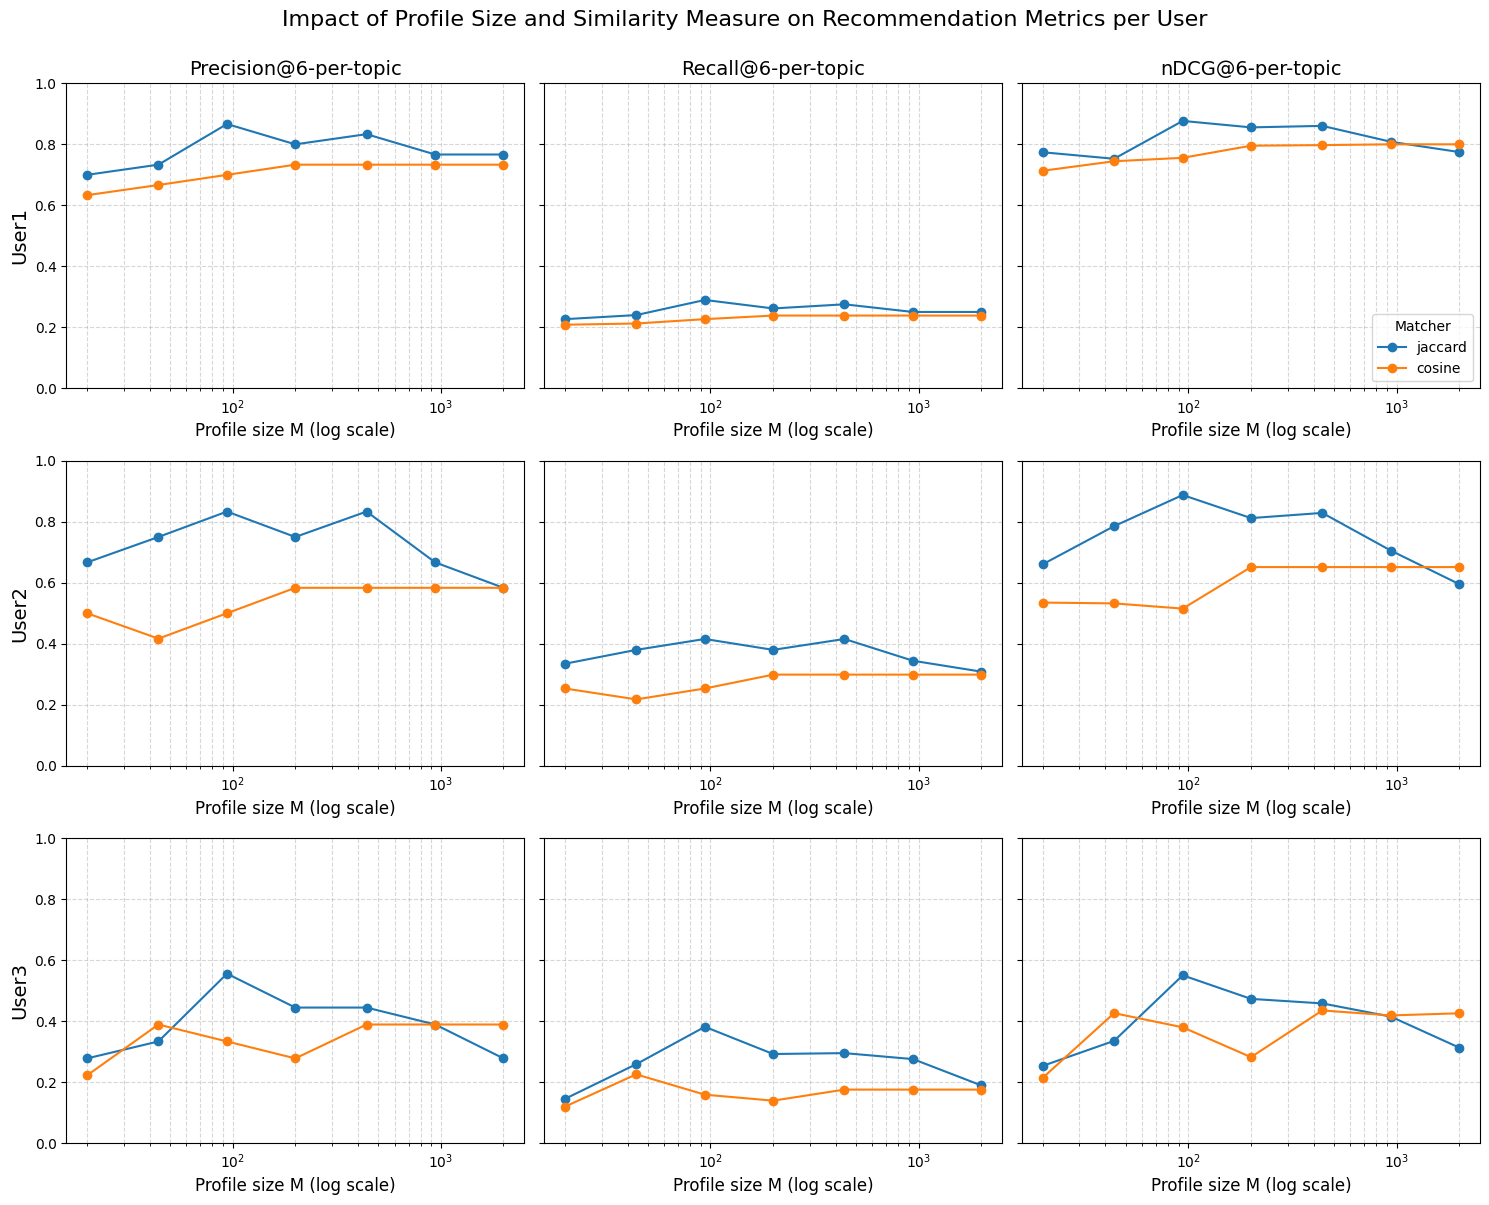

In [16]:
import matplotlib.pyplot as plt
import pandas as pd

# 0. Load your results into a DataFrame
df = pd.DataFrame(results)
print(df.head())

# 3. Define the plotting dimensions
users    = ['User1', 'User2', 'User3']
metrics  = ['Precision@6-per-topic', 'Recall@6-per-topic', 'nDCG@6-per-topic']
Ms       = Ms
matchers = [m[0] for m in matchers]

# 4. Create the grid of subplots
fig, axes = plt.subplots(
    nrows=len(users),
    ncols=len(metrics),
    figsize=(15, 12),
    sharey='row'
)

fig.suptitle("Impact of Profile Size and Similarity Measure on Recommendation Metrics per User",
            fontsize=16,
            y=1)

# Users plotted vertically and metric horizontally
for i, user in enumerate(users):
    df_user = df[df['User'] == user]
    for j, metric in enumerate(metrics):
        ax = axes[i, j]
        for matcher in matchers:
            method_df = (
                df_user[df_user['Matcher'] == matcher]
                    .set_index('M')
                    .reindex(Ms)
            )
            ax.plot(
                Ms,
                method_df[metric],
                marker='o',
                label=matcher
            )
        
        # Axis formatting
        ax.set_ylim(0, 1)
        ax.set_xlabel('Profile size M (log scale)', fontsize=12)
        ax.set_xscale('log')
        ax.grid(True, which="both", ls="--", alpha=0.5)

        # Titles & labels
        if i == 0:
            ax.set_title(metric, fontsize=14)
        if j == 0:
            ax.set_ylabel(user, fontsize=14)

axes[0, -1].legend(loc='lower right', title='Matcher')

plt.subplots_adjust(top=0.95)
plt.tight_layout()
plt.show()

### Part 2 Q2 Discussion

**General Performance**\
The binary Jaccard clearly outperforms Cosine for all users across all three metrics, peaking around `M≈100` and  degrading as noisy, low-signal terms dilute the binary overlap. In contrast, Cosine slowly improves as `M` grows, plateaus but never reaches Jaccard's peak accuracy; its use of TF–IDF weights and normalisation naturally downweights irrelevant terms, making it more robust to noise.

**User-by-user Precision**
- User 1: Peak P@6 = 0.87 (Jaccard @ `M=94`)
- User 2: Peak P@6 = 0.83 (Jaccard @ `M=94`)
- User 3: Peak P@6 = 0.56 (Jaccard @ `M=94`)

Users 1 and 2 used common, high-frequency keywords, allowing the recommender to suggest relevant songs that likely also contained those keywords; User 3 was created with more niche terms such as "monster", "demon", and "rage", which appear far less often and thus yield a much lower true-positive rate. This demonstrates how a system tuned to prevalent vocabulary can miss idiosyncratic tastes, as they tend to pick up broader signals instead.

**Recall and the Choice of N**\
The recall@6 rates (29%, 42%, and 38% for Users1-3 respectively) mean that even at optimal `M`, we retrieve under half of each user's likeable songs. If the goal is to capture a broader collection of user interests (higher recall), we could increase `N` to around 10, accepting a slightly lower Precision@N in exchange for more feedback signals and higher coverage. Conversely, if user attention is at a premium, `N=6` currently strikes a good balance.


**Metric Correlation**\
With a fixed `N=6` and binary relevance, the number of hits (i.e. true positives) in the top 6 drives Precision@6 and Recall@6 (scaled by total positives) which causes the metrics to have the same contour. nDCG is also highly correlated (albeit weighted by position, causing occasional discrepencies, e.g. `M=44` in User1). Beyond the constraints of this experiment, we would typically expect Precision and Recall to be inversely correlated as `N` varies, and nDCG to be more varied when operating on a rating scale.

**Matcher Recommendation**\
Use binary Jaccard with `M=~100` top terms per topic: it hits the sweet spot of conciseness and matching accuracy for varied user profiles.

# Part 3 User Evaluation

Conduct a "user study" of a hypothetical recommender system based on the method chosen in Part 2. Your evaluation in Part 2 will have included a choice of the number N of songs to show the user at any one time. For simplicity, suppose the user uses your system once per week. Simulate running the recommender system for 3 weeks and training the model at the end of Week 3 using interaction data obtained from the user, and testing the recommendations that would be provided to that user in Week 4

In [ ]:
N = 6 * 5  # 30
SEED = 42
rng = np.random.RandomState(SEED)

week_ranges = {
    1: range(0, 250),
    2: range(250, 500),
    3: range(500, 750),
}

df = df_weeks_train_concat.copy()
df['predicted_topic'] = pred_topics_weeks_train
for wk, idx_range in week_ranges.items():
    choices = rng.choice(list(idx_range), size=N, replace=False)
    df_sample = df.iloc[choices].copy()

    # Put like in first column for ease of use
    df_sample.insert(0, 'like', '?')
    cols = ['like', 'predicted_topic'] + [c for c in df_sample.columns if c not in ('like', 'predicted_topic')]

    df_sample = df_sample[cols]
    df_sample.to_csv(f'Week{wk}.tsv', sep='\t', index=False)
    print(f'Week{wk}.tsv written: {len(df_sample)} rows')


Week1.tsv written: 30 rows
Week2.tsv written: 30 rows
Week3.tsv written: 30 rows


In [ ]:
# Read in all three weeks
subject_likes_by_topic = defaultdict(list)

for wk in (1,):
    df = pd.read_csv(f'Week{wk}.tsv', sep='\t')
    # For every liked row, bucket its preprocessed lyric into its topic
    for doc, topic, like in zip(df['concat'], df['predicted_topic'], df['like']):
        if int(like) == 1:
            subject_likes_by_topic[topic].append(doc)

# Build profile vectors using the same topic_vectorizers from Part 2 Q1
real_profile = build_profile_vectors(subject_likes_by_topic, topic_vectorizers)

# Inspect
for topic, vec in real_profile.items():
    print(f">> Topic {topic!r} profile has {vec.nnz} nonzero terms")

# From before, song_by_topic_rec holds one sparse tfidf matrix per topic for Week 4 candidates.
recs = []
df4_filled = df_weeks_rec_concat.copy()
df4_filled['predicted_topic'] = pred_topics_weeks_rec
for topic, prof_vec in real_profile.items():
    # Trim to top-M
    trim_topic_prof = trim_profile(prof_vec, M=100)

    pred_idxs, scores = recommend_songs(trim_topic_prof, song_by_topic_rec[topic], jaccard_scores, N=6)


    for rel_rank, (pred_idx, score) in enumerate(zip(pred_idxs, scores), start=1):
        global_idx = indices_by_topic_rec[topic][pred_idx]
        row = df4_filled.iloc[global_idx].to_dict()
        row.update({
            'score': score,
            'rank_in_topic': rel_rank,
            'like': '?'  # placeholder for real user feedback
        })
        recs.append(row)

week4_recs = pd.DataFrame(recs).reset_index(drop=True)
cols = ['like', 'predicted_topic'] + [c for c in week4_recs.columns if c not in ('like', 'predicted_topic')]
week4_recs = week4_recs[cols]

week4_recs.to_csv('Week4.tsv', sep='\t', index=False)
print("Wrote", len(week4_recs), "rows to Week4.tsv")


>> Topic 'dark' profile has 295 nonzero terms
>> Topic 'personal' profile has 80 nonzero terms
>> Topic 'sadness' profile has 53 nonzero terms
Wrote 18 rows to Week4.tsv


In [21]:
# reload the filled‐in file
df4_filled = pd.read_csv('Week4.tsv', sep='\t')
df4_filled.columns = df4_filled.columns.str.strip()
# print(df4_filled.columns.tolist())

# compute metrics per topic, then macro‐average
results = []
for tp, group in df4_filled.groupby('predicted_topic'):
    y_true = group['like'].astype(int).values
    # our recommendations were in rank‐order already,
    # so predicted indices = [0,1,2,3,4,5]
    idxs = np.arange(len(y_true))
    p, r, ndcg = compute_metrics(y_true, idxs, N=6)
    results.append({'topic': tp, 'P@6': p, 'R@6': r, 'nDCG@6': ndcg})

df_res = pd.DataFrame(results)
print("Per‐topic metrics:\n", df_res)
print("\nMacro‐averaged metrics:")
print(df_res[['P@6','R@6','nDCG@6']].mean())

Per‐topic metrics:
               topic       P@6  R@6    nDCG@6
0   dark             0.333333  1.0  0.650921
1   personal         0.333333  1.0  1.000000
2   sadness          0.500000  1.0  0.932521

Macro‐averaged metrics:
P@6       0.388889
R@6       1.000000
nDCG@6    0.861147
dtype: float64


### Discussion
The per-topic & macro-averaged metrics are displayed in the above table. Interestingly, although 6 songs per topic were displayed in each of the training weeks, no lifestyle or emotional topic songs were ever liked, and hence were not recommended in Week 4.

- Average precision@6 (39%) was noticeably lower than in the simulated users (56-87%), which indicates that the keyword-based profile overestimates real listening preferences (it does not account for factors other than keywords).
- nDCG@6 remained high, indicating that when the user did like songs, they tended to appear near the top of each topic card. This early placement likely boosted perceived satisfaction, even if latter matches were not to liking. There could have also been a psychological factor (Primacy) that made these first options more appealing, however further studies would need to be conducted to confirm this.

#### Limitations of Real User Feedback/Usage
- Recall@6 was erroneously calculated as 100%; **it is NOT a valid measure in this setting**. In our live user‐study we only collected like/dislike labels for the 6 songs we chose to show per topic (i.e. 18 songs total across three topics). Recall, however, is defined as `# liked songs in top-6/# liked songs in the entire candidate pool`. Since we never asked the participant the other 44 songs of that topic in the Week 4 pool, we have no ground‐truth for those: any songs they would have liked, but were not shown, ought to count as false negatives (FN). However, we treated them as true negatives by default. That assumption drove our observed Recall@6 to 100%, which is meaningless.
- Furthermore, in the training weeks, we only got the likes for 30*3 songs, unlike the 250\*3 in the simulation.
- The participant judged the songs purely on the title, artist genre and lyric snippet (with stopwords filtered). In reality, melody, instrumentation, rhythm and metre, and vocal style heavily influence enjoyment. Our user interface only displays surface-text signals and misses nuance like rhyme scheme, verse structure, or stylistic flair.

### Personal tastes and Feedback
The participant had a vehement disliking to ALL country songs and additionally expressed disgust at certain artists, such as Imagine Dragons and Shawn Mendes, underpinning that prior associations can override the lyrical features of the song. Despite this strong feedback, one country song still appeared in the Week 4 recommendations. Additionally, the participant recognised a couple of favourite songs and artists and expressed a want for more of those. Altogether, this emphasised the lack of a function to record a stronger signal than a simple binary like/dislike -- such as being able to add to a playlist, or to 'block' or 'follow' an artist.

Repetitive and "uninspired" lyrics scored poorly, whereas songs with clear rhymes or evocative imagery tended to be liked. This reveals another aspect of the complex musical preferences of human users; there is a much more complicated process behind liking a song than just the appearance of certain keywords -- the Part 2 simulation is very simplified model of user behaviour.



